# JungHyun Bang
# 220544997/1




Title : predicting protein solubility 

data set used: eSOL: Solubility data for Ecoli proteins

DOI: [10.18908/lsdba.nbdc00440-001](https://dbarchive.biosciencedbc.jp/en/esol/data-1.html)


In [83]:
import os
import pandas as pd
import requests
import json
import time

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

from sklearn.model_selection import train_test_split


from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
# define dirs
dataset_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\Dataset"
log_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\logs"

In [146]:

d1 = pd.read_csv(os.path.join(dataset_dir, "esol.csv"))
print(d1.columns)


Index(['JW_ID', 'ECK number', 'B number', 'Gene name K-12', 'Locus name K-12',
       'Synonyms of locus names K-12', 'Solubility (%)', 'Yield (uM)',
       'Yield (ug/ml)', 'Minus Sol (%)', 'TF Sol (%)', 'GroE Sol (%)',
       'KJE Sol (%)', 'Minus Yield (uM)', 'TF Yield (uM)', 'GroE Yield (uM)',
       'KJE Yield (uM)', 'Minus Yield (ug/ml)', 'TF Yield (ug/ml)',
       'GroE Yield (ug/ml)', 'KJE Yield (ug/ml)', 'Calculated MW (kDa)',
       'Calculated pI', 'Type of gene product', 'Gene product description',
       'Cell location', 'Structure (PDB) ID', 'SCOP assignment'],
      dtype='object')


Okay first things first lets try and identify the dimensions that confer with solubility.

Deffo Solubility (%) will be our lable, so this needs to be non-NAN 
"Calculated MW (kDa)", "Calculated pI" these are features that will have direct impact on the solubility i think. We should use this.

biologically speeking, Yeild data('Yield (uM)','Yield (ug/ml)') will have some correlation with solubility but this may result in high correlation issues.

'Type of gene product', 'Cell location' These features may have some critical instance class bias as some classes of proteins may be less expressable(less soluble)  lets keep this for future use.

In [35]:
cols = ["Solubility (%)", "Calculated MW (kDa)", "Calculated pI", "Yield (uM)", "Yield (ug/ml)", "Type of gene product", "Cell location"]
crit_col = ["Solubility (%)", "Calculated MW (kDa)", "Calculated pI"]
print(f"n Tot insatnce: {len(d1)}")

print("n NAN per col ")
print(d1[cols].isna().sum())
print()

print("% of NAN per col")
print(d1[cols].isna().mean())
print()


print("instances with complete data for critical columns")
mask_valid = d1[crit_col].notna().all(axis=1)
print(f"n Logical test ok instances:  {mask_valid.sum()}")
print(f"% Logical test ok instances: {mask_valid.mean()}")


n Tot insatnce: 4132
n NAN per col 
Solubility (%)          959
Calculated MW (kDa)       0
Calculated pI             0
Yield (uM)              959
Yield (ug/ml)           959
Type of gene product      0
Cell location             2
dtype: int64

% of NAN per col
Solubility (%)          0.232091
Calculated MW (kDa)     0.000000
Calculated pI           0.000000
Yield (uM)              0.232091
Yield (ug/ml)           0.232091
Type of gene product    0.000000
Cell location           0.000484
dtype: float64

instances with complete data for critical columns
n Logical test ok instances:  3173
% Logical test ok instances: 0.7679090029041626


Okay i think we can proceed with this.
Now for better model development, we need more features. From UNIPROT, we will be able to get these information....
need some data crawling.

first we will clean the data and append the sequence column.

In [ ]:
optional_cols = ["Yield (uM)", "Yield (ug/ml)", "Type of gene product", "Cell location"]
# first we need the lable.. so 
cdf = d1.dropna(subset=["Solubility (%)"]).copy()
print("Clean shape:", cdf.shape)
print(cdf[crit_col].isna().sum())

Clean shape: (3173, 28)
Solubility (%)         0
Calculated MW (kDa)    0
Calculated pI          0
dtype: int64


okay, no need for further cleaning. 

(3173, 3)


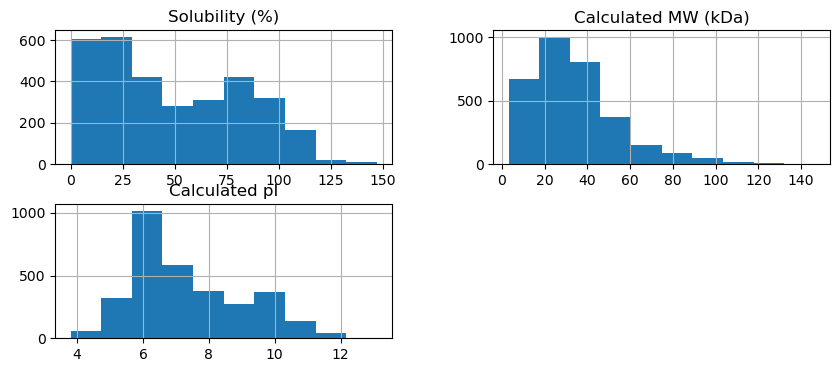

In [152]:
cdf_woptional = cdf[optional_cols].copy()
#storing the additioanl dimensions just incase for further evaluation.

#inspecting the feature distribution.
cdf_assaydf = cdf[crit_col].copy()
cdf_assaydf.describe()
cdf_assaydf.hist(figsize=(10, 4))
print(cdf_assaydf.shape)

Nice, nothing seems unusual. Lets now get the sequence data.

so by searching the Uniprot with the JW_ID, I have discovered this resolves alot of issues(single result).

so we will use the jw_id col as our search varaible.

Its been a while since I used this method.. so lets check the backend json of the search result for JW2231

In [39]:
Targ_ULR = "https://rest.uniprot.org/uniprotkb/search"
params = {
    "query": "JW2231",
    "format": "json",   # full JSON
}

response = requests.get(Targ_ULR, params=params)
print("Status:", response.status_code)

data = response.json()
print(json.dumps(data, indent=4))

save_path = "JW2231_uniprot.json"

# with open(save_path, "w", encoding="utf-8") as f:
#     json.dump(data, f, indent=4)

Status: 200
{
    "results": [
        {
            "entryType": "UniProtKB reviewed (Swiss-Prot)",
            "primaryAccession": "P27294",
            "secondaryAccessions": [
                "P77545"
            ],
            "uniProtkbId": "INAA_ECOLI",
            "entryAudit": {
                "firstPublicDate": "1992-08-01",
                "lastAnnotationUpdateDate": "2025-06-18",
                "lastSequenceUpdateDate": "1997-11-01",
                "entryVersion": 149,
                "sequenceVersion": 3
            },
            "annotationScore": 2.0,
            "organism": {
                "scientificName": "Escherichia coli (strain K12)",
                "taxonId": 83333,
                "lineage": [
                    "Bacteria",
                    "Pseudomonadati",
                    "Pseudomonadota",
                    "Gammaproteobacteria",
                    "Enterobacterales",
                    "Enterobacteriaceae",
                    "Escherichia"


            "sequence": {
                "value": "MAVSAKYDEFNHWWATEGDWVEEPNYRRNGMSGVQCVERNGKKLYVKRMTHHLFHSVRYPFGRPTIVREVAVIKELERAGVIVPKIVFGEAVKIEGEWRALLVTEDMAGFISIADWYAQHAVSPYSDEVRQAMLKAVALAFKKMHSINRQHGCCYVRHIYVKTEGNAEAGFLDLEKSRRRLRRDKAINHDFRQLEKYLEPIPKADWEQVKAYYYAM",
                "length": 216,
                "molWeight": 25296,
                "crc64": "49B8E72F553113FD",
                "md5": "B5EC566BFBE36672B78744D86C0B9E27"
            },
This is the part that we are interested in.

Now lets just extract this bit..

In [40]:
def fetch_uniprot_seq_by_jw(jw_id):
    if pd.isna(jw_id):
        return None, "JW_ID is NaN"

    query = f"{jw_id} AND organism_id:83333"
    
    params = {
        "query": query,
        "fields": "accession,id,gene_names,organism_id,sequence",
        "format": "tsv",
        "size": 5
    }

    try:
        r = requests.get(Targ_URL, params=params)

        if r.status_code != 200:
            return None, f"HTTP {r.status_code}: {r.text[:200]}"

        text = r.text.strip()
        if not text:
            return None, "Empty response"

        lines = text.splitlines()
        if len(lines) <= 1:
            return None, "No hits"

        header = lines[0].split("\t")
        if "Sequence" not in header:
            return None, f"'Sequence' column missing. Header={header}"

        seq_idx = header.index("Sequence")
        first = lines[1].split("\t")
        seq = first[seq_idx]

        if seq == "":
            return None, "Empty sequence"

        return seq, None

    except Exception as e:
        return None, f"Exception: {str(e)}"


In [41]:
def add_sequences_with_progress(cdf, id_col="JW_ID", sleep_sec=0.2):
    df = cdf.copy()
    df["UniProt_seq"] = None

    unique_ids = df[id_col].dropna().unique()
    total = len(unique_ids)

    id_to_seq = {}
    error_log = []

    for i, jw in enumerate(unique_ids, start=1):

        seq, err = fetch_uniprot_seq_by_jw(jw)
        id_to_seq[jw] = seq        
        if err is None:
            print(f"[{i}/{total}] {jw}: OK")                # keeping  track of the progression
        else:
            print(f"[{i}/{total}] {jw}: FAIL → {err}")
            error_log.append({"JW_ID": jw, "Error": err})

        time.sleep(sleep_sec)

    df["UniProt_seq"] = df[id_col].map(id_to_seq)
    err_df = pd.DataFrame(error_log)
    return df, id_to_seq, err_df

In [43]:
cdf_seq, seq_map, err_df = add_sequences_with_progress(cdf)
cdf_seq.to_csv(os.path.join(dataset_dir, "esol_with_sequences.csv"), index=False)
err_df.to_csv(os.path.join(log_dir, "uniprot_sequence_errors.csv"), index=False)

print("DONE!")


[1/3173] JW0002: OK
[2/3173] JW0003: OK
[3/3173] JW0004: OK
[4/3173] JW0005: OK
[5/3173] JW0007: OK
[6/3173] JW0008: OK
[7/3173] JW5001: OK
[8/3173] JW0012: OK
[9/3173] JW0013: OK
[10/3173] JW0014: OK
[11/3173] JW5002: OK
[12/3173] JW0019: OK
[13/3173] JW0022: OK
[14/3173] JW0023: OK


KeyboardInterrupt: 

In [155]:
cdf_final = cdf_seq.dropna(subset=["UniProt_seq"]).copy()
print("Final dataset shape:", cdf_final.shape)
cdf_final.to_csv(os.path.join(dataset_dir,"cdf_final.csv"), index=False)

crit_col2 = ["Solubility (%)", "Calculated MW (kDa)", "Calculated pI","UniProt_seq"]

assayfianldf = cdf_final[crit_col2].copy()
print(assayfianldf.shape)

Final dataset shape: (3150, 29)
(3150, 4)


Out of the 3173 entries with valid solubility measurements, 23 proteins could not be mapped to UniProtKB using their JW_ID identifiers. These entries were excluded from sequence-based modelling due to missing primary structure information. The missing cases were logged separately and likely correspond to deprecated or unannotated ORFs in the E. coli K-12 reference strain.

The final dataset contained 3150 instances and 29 dimensions


# Feature engineering

##### Basic features (Level 2)
- Length
- 20 AA fractional composition (20개)
- Residue group fractions
- frac_pos = (K+R+H)/L
- frac_neg = (D+E)/L
- frac_charged = (K+R+H+D+E)/L
- frac_polar = (S+T+N+Q+Y+C)/L
- frac_hydrophobic = (A+V+L+I+M+F+W+Y)/L
- frac_aromatic = (F+W+Y)/L
- frac_turn = (N+G+P+S)/L

##### Extended features (Level 2)
- GRAVY
- Aliphatic index
- Aromaticity index
- Instability index
- Net charge at pH 7


In [157]:
import math
import pandas as pd

AA20 = list("ACDEFGHIKLMNPQRSTVWY")

# Kyte–Doolittle hydropathy index (for GRAVY)
KD = {"A": 1.8, "C": 2.5, "D": -3.5, "E": -3.5, "F": 2.8,
    "G": -0.4, "H": -3.2, "I": 4.5, "K": -3.9, "L": 3.8,
    "M": 1.9, "N": -3.5, "P": -1.6, "Q": -3.5, "R": -4.5,
    "S": -0.8, "T": -0.7, "V": 4.2, "W": -0.9, "Y": -1.3}

# pKa values for net charge at pH 7 (very standard approximations)
PKA_N_TERM = 9.6
PKA_C_TERM = 2.4
PKA_SIDE = {"D": 4.0,"E": 4.4,"H": 6.5,"C": 8.5,
            "Y": 10.0,"K": 10.5,"R": 12.5,}

def henderson_hasselbalch_acid(pH, pKa):        #deprotonation for DECY
    return 1.0 / (1.0 + 10 ** (pKa - pH))

def henderson_hasselbalch_base(pH, pKa):        #deprotonation for KRH
    return 1.0 / (1.0 + 10 ** (pH - pKa))

def seq_to_features(seq, pH=7.0):           # feat dict 
    if not isinstance(seq, str):            # error guard
        return None, "Sequence is not a string"

    seq = seq.strip().upper()
    clean = [aa for aa in seq if aa in AA20]
    qlen = len(clean)

    if qlen == 0:
        return None, "Sequence contains no valid amino acids (length=0)"

    try:
        counts = {aa: 0 for aa in AA20}     # initialisiong count dict
        for aa in clean:
            counts[aa] += 1

        fracs = {aa: counts[aa] / qlen for aa in AA20}      # fracctionating or getting %
        pos_set = set("KRH")                                # converting to single str per physical chars.
        neg_set = set("DE")
        charged_set = set("KRHDE")
        polar_set = set("STNQYC")
        hydrophobic_set = set("AVLIMFWY")
        aromatic_set = set("FWY")
        turn_set = set("NGPS")

        frac_pos = sum(fracs[a] for a in pos_set)           
        frac_neg = sum(fracs[a] for a in neg_set)
        frac_charged = sum(fracs[a] for a in charged_set)
        frac_polar = sum(fracs[a] for a in polar_set)
        frac_hydrophobic = sum(fracs[a] for a in hydrophobic_set)
        frac_aromatic = sum(fracs[a] for a in aromatic_set)
        frac_turn = sum(fracs[a] for a in turn_set)

        # gravy
        gravy = sum(KD[a] for a in clean) / qlen

        # aliphatic index
        xA = fracs["A"]
        xV = fracs["V"]
        xI = fracs["I"]
        xL = fracs["L"]

        aliphatic_index = 100.0 * (xA + 2.9*xV + 3.9*(xI + xL))     #PMID: 7462208

        # aromaticity index
        aromaticity_index = frac_aromatic

        # placeholder instability index : i noticed the calculations are quite complex for this we will come back to this later.
        instability_index = None            # PMID 2075190

        # net charge
        n_term_charge = henderson_hasselbalch_base(pH, PKA_N_TERM)
        c_term_charge = -henderson_hasselbalch_acid(pH, PKA_C_TERM)

        side_charge = 0.0
        for aa in clean:
            if aa in ("D","E","C","Y"):
                side_charge += -henderson_hasselbalch_acid(pH, PKA_SIDE[aa])
            elif aa in ("K","R","H"):
                side_charge += henderson_hasselbalch_base(pH, PKA_SIDE[aa])

        net_charge = n_term_charge + c_term_charge + side_charge

        # collect
        feats = {
            "length": L,
            "gravy": gravy,
            "aliphatic_index": aliphatic_index,
            "aromaticity_index": aromaticity_index,
            "instability_index": instability_index,
            "net_charge_pH7": net_charge,
            "frac_pos": frac_pos,
            "frac_neg": frac_neg,
            "frac_charged": frac_charged,
            "frac_polar": frac_polar,
            "frac_hydrophobic": frac_hydrophobic,
            "frac_aromatic": frac_aromatic,
            "frac_turn": frac_turn
        }

        for aa in AA20:
            feats[f"aa_{aa}"] = fracs[aa]

        return feats, None

    except Exception as e:
        return None, f"Exception during feature extraction: {str(e)}"

In [158]:
def combdimensionmatrix(df, seq_col="UniProt_seq",
                         extra_cols=("Calculated MW (kDa)", "Calculated pI")):

    feat_rows = []
    idx_list = []
    error_log = []

    for idx, seq in df[seq_col].items():
        feats, err = seq_to_features(seq)

        if err is not None:
            error_log.append({"Index": idx, "Error": err})
            continue

        feat_rows.append(feats)
        idx_list.append(idx)

    X = pd.DataFrame(feat_rows, index=idx_list)

    if extra_cols is not None:
        extra = df.loc[idx_list, list(extra_cols)].copy()
        X = pd.concat([X, extra], axis=1)

    error_df = pd.DataFrame(error_log)

    return X, error_df

# Planning the model

- Although solubility is naturally a continuous property, some applications (e.g., recombinant protein expression screening) only require a binary soluble/insoluble decision.
Therefore, after training a regression model, we additionally examined various classification thresholds to identify the optimal threshold based on maximizing F1-score.



so, the main model will be a regression(Ridge) with target = solubility %

Metrics: 
- RMSE 
- MAE
- $R^2$

Cross validation
KFold + confusion matrix 

Learning curve
Hyperparameter tuning: Finding ridge a val.


further classification with the results(?)

Although solubility is often treated as a binary attribute in many biochemical applications, in practice it is a continuous physicochemical property that spans a spectrum between fully soluble and completely insoluble, depending on environmental conditions. The original esol dataset provided contains the solubility report as a % demonstrating this gradual variation of solubility instead of a threshold classification. Regarding this project, it was concluded formulating the problem as a regression is more approprate based on 2 main reasons: 1. Formulating solubility in a classification task leads to substantial information loss due to the continuous experimental data being forced in to arbitrary categories; 2. to formulate this in to a classification, a decision has to be made regarding the thresholds, however, mayny different programs, laboratories will use different procedures and constants(or conditions) thus, it is difficult to justify a specific threshold. 

Regarding the regression model design, various models were considered ranging from OLS, Ridge, Lasso and non-linear models. Proteins and data generated from the sequence tends to exhibit substantial multicollinearity due to the given biophysical properties which makes regularised models particularly useful. However, biological data also exhibits high degree of noise and outliers. For this project, it was decided the baseline model will be constructed with the Ridge regression due to its properties of variance stabilisation and robust generalisation with minimum feature loss. Also, the Lasso was thought to be particularly non-benificial in this case due to the likelyhood of elimiating correlated aminoacid discriptors while Tree-based models were also thought as a relatively weak candidate in this situation due to the tendency to overfit small noises and also reduction in interpretability. Although lacking prior knowledge to ElasticNet model, this model was also thoguht to be worth testing along the other models. 

Regarding the Parameters, as a standard, RMSE, MAE and $R^2$ were considered to be the baseline parameters for evaluation, while considering the model will be dealing with biological data, which often requries identification of trends, 


In [80]:
X_features_clean = X_features.dropna(axis=1, how="all")
# we left the instability column blank...
# we need to drop this.


# setting target.
y_reg = cdf_final.loc[X_features_clean.index, "Solubility (%)"]

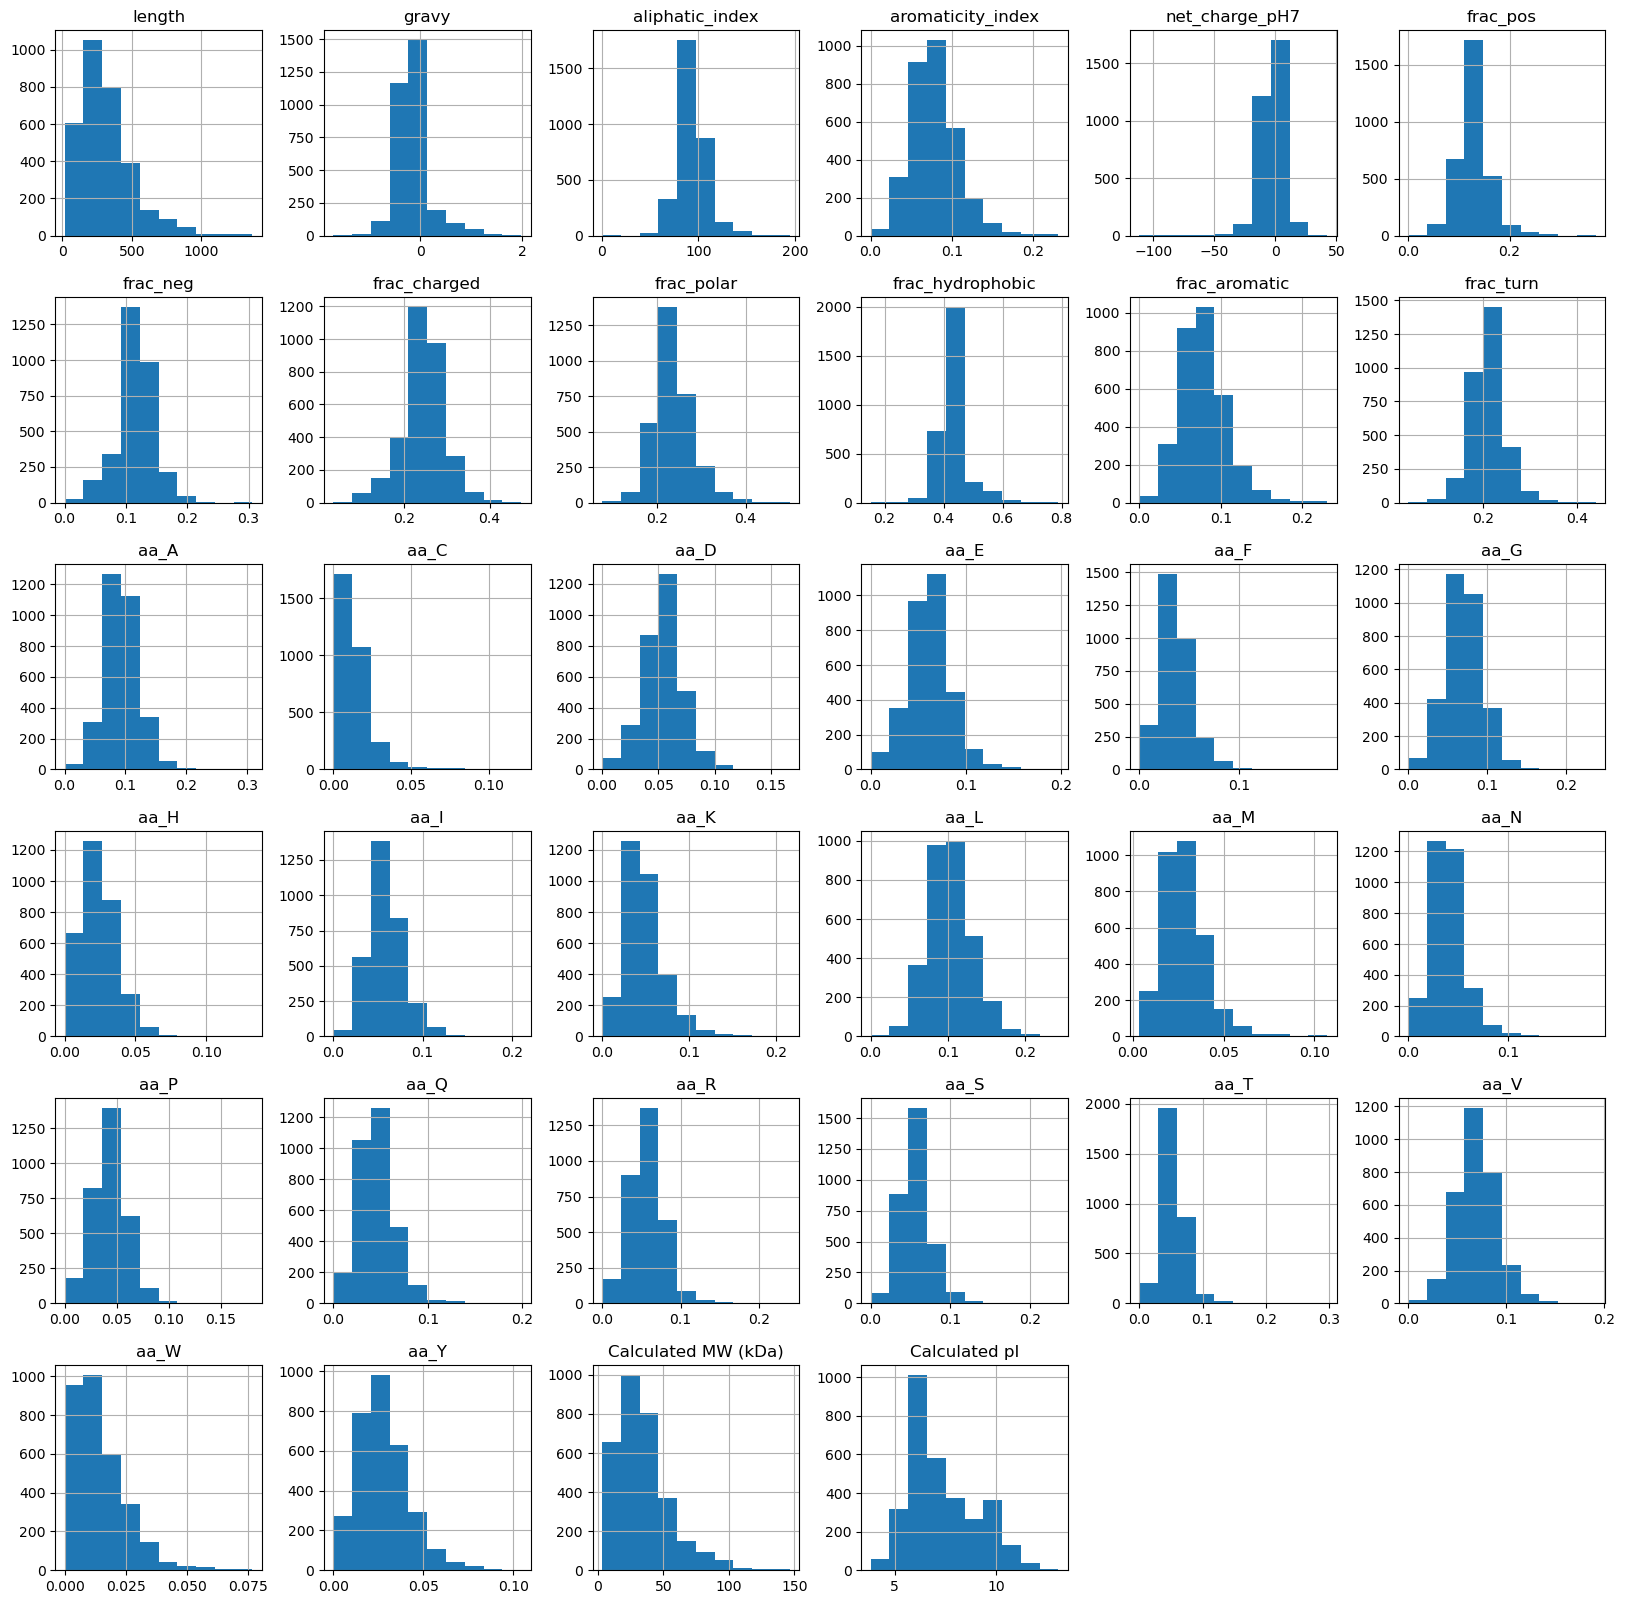

In [90]:
import matplotlib.pyplot as plt
X_features_clean.describe()
X_features_clean.hist(figsize=(20, 20))
plt.savefig("feature_histograms.png", dpi=300)

In [92]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X_features_clean, y_reg,
    test_size=0.2,
    random_state=42
)

print("Train:", X_tr.shape, y_tr.shape)
print("Test :", X_te.shape, y_te.shape)

Train: (2520, 34) (2520,)
Test : (630, 34) (630,)


In [98]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


def Ev_mod(scaler, X_tr, Y_tr, X_te, Y_te, alpha=1.0):
    pipe = Pipeline([
        ("sc", scaler),
        ("rg", Ridge(alpha=alpha))
    ])
    pipe.fit(X_tr, y_tr)

    #initial pred
    y_tr_pred = pipe.predict(X_tr)
    y_te_pred = pipe.predict(X_te)

    # metrics
    tr_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    te_rmse = np.sqrt(mean_squared_error(y_te, y_te_pred))
    tr_r2 = r2_score(y_tr, y_tr_pred)
    te_r2 = r2_score(y_te, y_te_pred)
    tr_mae = mean_absolute_error(y_tr, y_tr_pred)
    te_mae = mean_absolute_error(y_te, y_te_pred)

    return {
        "train_RMSE": tr_rmse,
        "test_RMSE": te_rmse,
        "train_MAE": tr_mae,
        "test_MAE": te_mae,
        "train_R2": tr_r2,
        "test_R2": te_r2
    }    


if __name__ == "__main__":
    results = {"StandardScaler": Ev_mod(StandardScaler(), X_tr, y_tr, X_te, y_te),
               "RobustScaler":   Ev_mod(RobustScaler(), X_tr, y_tr, X_te, y_te)}

# Convert to a clean table
df_results = pd.DataFrame(results).T   # transpose for readability
print(df_results.round(3))

                train_RMSE  test_RMSE  train_MAE  test_MAE  train_R2  test_R2
StandardScaler      26.079     26.090      21.42    21.059     0.387    0.398
RobustScaler        26.079     26.088      21.42    21.058     0.387    0.398


In [103]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    QuantileTransformer,
    PowerTransformer,
    FunctionTransformer,
)
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(scaler, X_tr, y_tr, X_te, y_te, alpha=1.0):
    pipe = Pipeline([
        ("sc", scaler),
        ("rg", Ridge(alpha=alpha)),
    ])
    pipe.fit(X_tr, y_tr)

    y_tr_pred = pipe.predict(X_tr)
    y_te_pred = pipe.predict(X_te)

    return {
        "train_RMSE": np.sqrt(mean_squared_error(y_tr, y_tr_pred)),
        "test_RMSE":  np.sqrt(mean_squared_error(y_te, y_te_pred)),
        "train_MAE":  mean_absolute_error(y_tr, y_tr_pred),
        "test_MAE":   mean_absolute_error(y_te, y_te_pred),
        "train_R2":   r2_score(y_tr, y_tr_pred),
        "test_R2":    r2_score(y_te, y_te_pred),
    }

scaler_dict = {
    "None":            FunctionTransformer(validate=False),              # 스케일링 안 함
    "StandardScaler":  StandardScaler(),
    "RobustScaler":    RobustScaler(),
    "MinMaxScaler":    MinMaxScaler(),
    "MaxAbsScaler":    MaxAbsScaler(),
    "QuantileNorm":    QuantileTransformer(output_distribution="normal", random_state=42),
    "Power_YeoJohnson": PowerTransformer(method="yeo-johnson"),
}

results = {}
for name, scaler in scaler_dict.items():
    res = evaluate_model(scaler, X_tr, y_tr, X_te, y_te, alpha=1.0)
    results[name] = res

df_results = pd.DataFrame(results).T
print(df_results.round(3))


                  train_RMSE  test_RMSE  train_MAE  test_MAE  train_R2  \
None                  26.397     26.239     21.909    21.638     0.372   
StandardScaler        26.079     26.090     21.420    21.059     0.387   
RobustScaler          26.079     26.088     21.420    21.058     0.387   
MinMaxScaler          26.108     26.109     21.473    21.164     0.386   
MaxAbsScaler          26.095     26.054     21.457    21.119     0.387   
QuantileNorm          25.245     25.154     20.581    20.240     0.426   
Power_YeoJohnson      25.225     25.068     20.507    20.204     0.427   

                  test_R2  
None                0.391  
StandardScaler      0.398  
RobustScaler        0.398  
MinMaxScaler        0.397  
MaxAbsScaler        0.400  
QuantileNorm        0.440  
Power_YeoJohnson    0.444  


No real difference observed between the scalers...
as seen above, the distribution of the data is some what stable in a sense that although some degree of skewing is observed, they are generally in a shape of a normal distribution with no exceedingly long tail. no real signatures of significant outliers.. so as expected both scalers perform almost identically.

with simple mathematics.. the difference in the test_MAE can be deduced tobe 0.002/21.42*100 = 0.0093% which is negligable..
just for completeness, we will screen for other scaling methods too including MinMAx, QuantileTransformer, PowerTransformer

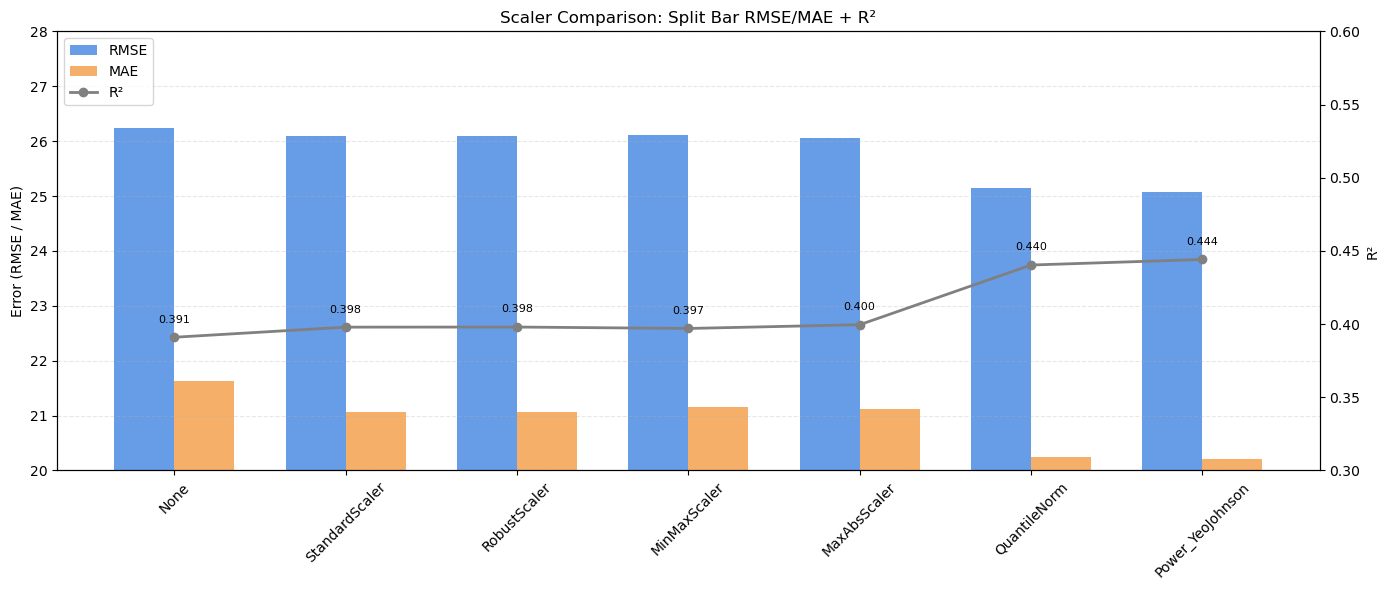

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

scalers = df_results.index.tolist()
x = np.arange(len(scalers))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14,6))

# -----------------------------
# Bar positions (좌우 offset)
# -----------------------------
rmse_pos = x - width/2
mae_pos  = x + width/2

# -----------------------------
# RMSE bar
# -----------------------------
ax1.bar(rmse_pos, df_results["test_RMSE"], 
        width, label="RMSE", color="#4C8BE2", alpha=0.85)

# -----------------------------
# MAE bar
# -----------------------------
ax1.bar(mae_pos, df_results["test_MAE"], 
        width, label="MAE", color="#F5A14E", alpha=0.85)

# -----------------------------
# R² line (right axis)
# -----------------------------
ax2 = ax1.twinx()

ax2.plot(x, df_results["test_R2"], 
         marker="o", color="grey", linewidth=2, label="R²")

# Annotation (수치 표시)
for xi, yi in zip(x, df_results["test_R2"]):
    ax2.text(xi, yi + 0.01, f"{yi:.3f}", color="black",
             fontsize=8, ha="center")

# -----------------------------
# Axis settings
# -----------------------------
ax1.set_ylabel("Error (RMSE / MAE)")
ax1.set_ylim(20, 28)
ax1.set_xticks(x)
ax1.set_xticklabels(scalers, rotation=45)

ax2.set_ylabel("R²")
ax2.set_ylim(0.3, 0.6)

ax1.grid(axis="y", linestyle="--", alpha=0.3)

plt.title("Scaler Comparison: Split Bar RMSE/MAE + R²")

# -----------------------------
# Merge legends
# -----------------------------
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()
plt.savefig("Figuredump/ScalerinitialPerformance.png", dpi=300)

Interesting to see the PowerTransformer(Yeojohnson) to be performing the bets. form the Scikitlearn official repo,.
"Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like." It is unclear if this will be beneficial for our dataset, as it is a biological data set with noise ... 


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import (
    FunctionTransformer,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    QuantileTransformer,
    PowerTransformer,
)
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

# -------------------------------------------------
# CV 설정
# -------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []

for name, scaler in scaler_dict.items():
    pipe = Pipeline([
        ("sc", scaler),
        ("rg", Ridge(alpha=1.0)),
    ])

    # R² (그냥 양수)
    cv_r2 = cross_val_score(
        pipe, X_features_clean, y_reg,
        cv=cv,
        scoring="r2"
    )

    # RMSE: neg_mean_squared_error -> 양수 RMSE로 변환
    cv_mse = cross_val_score(
        pipe, X_features_clean, y_reg,
        cv=cv,
        scoring="neg_mean_squared_error"
    )
    cv_rmse = np.sqrt(-cv_mse)

    # MAE: neg_mean_absolute_error -> 양수 MAE로 변환
    cv_mae = cross_val_score(
        pipe, X_features_clean, y_reg,
        cv=cv,
        scoring="neg_mean_absolute_error"
    )
    cv_mae = -cv_mae

    rows.append({
        "Scaler": name,
        "R2_mean":   cv_r2.mean(),
        "R2_std":    cv_r2.std(),
        "RMSE_mean": cv_rmse.mean(),
        "RMSE_std":  cv_rmse.std(),
        "MAE_mean":  cv_mae.mean(),
        "MAE_std":   cv_mae.std(),
    })

cv_results = pd.DataFrame(rows).set_index("Scaler")
print(cv_results.round(3))


                  R2_mean  R2_std  RMSE_mean  RMSE_std  MAE_mean  MAE_std
Scaler                                                                   
None                0.368   0.023     26.495     0.628    21.935    0.528
StandardScaler      0.378   0.025     26.273     0.657    21.482    0.535
RobustScaler        0.378   0.025     26.273     0.657    21.482    0.535
MinMaxScaler        0.377   0.023     26.294     0.626    21.550    0.509
MaxAbsScaler        0.378   0.024     26.272     0.637    21.523    0.514
QuantileNorm        0.412   0.026     25.538     0.654    20.728    0.502
Power_YeoJohnson    0.416   0.028     25.465     0.699    20.632    0.533


so interms of the performace, it seems the power transfer scaler is consistently performing the best. while the standard and NO-scaler are performing around the same.

With regards to the metrics used here,
- $R^2$ : how well the model explains the variance
- MAE : Mean absolute error - How well does the model predict
- RMSE : Root mean squared error: how off the model prediction is to the real value.
purely based on these metrics, the Power transfer scaler is performing the best.

However, the data set that we are using here is a biological datset, which is composed of a mixture of experimental vlaues and biophysical vlaues calculated from the sequence data while the target is an experiemntal value(solubility %) to some extent, the correlation or spacial arangement between the feature matrix may play some critical role for the proper prediction..(not sure need to check if this is right)

GPT said try spearman ---- look in to what this actually is 




In [128]:
from scipy.stats import spearmanr

sp_rows = []

for name, scaler in scaler_dict.items():
    pipe = Pipeline([
        ("sc", scaler),
        ("rg", Ridge(alpha=1.0)),
    ])

    sp_scores = []

    for tr_idx, te_idx in cv.split(X_features_clean):
        Xtr = X_features_clean.iloc[tr_idx]
        Xte = X_features_clean.iloc[te_idx]
        ytr = y_reg.iloc[tr_idx]
        yte = y_reg.iloc[te_idx]

        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xte)

        rho, _ = spearmanr(yte, pred)
        sp_scores.append(rho)

    sp_rows.append({
        "Scaler": name,
        "Spearman_mean": np.mean(sp_scores),
        "Spearman_std":  np.std(sp_scores),
    })

sp_df = pd.DataFrame(sp_rows).set_index("Scaler")

# 🔥 기존 cv_results 에 Spearman 컬럼 붙이기
cv_results_full = cv_results.join(sp_df)

print(cv_results_full.round(3))


                  R2_mean  R2_std  RMSE_mean  RMSE_std  MAE_mean  MAE_std  \
Scaler                                                                      
None                0.368   0.023     26.495     0.628    21.935    0.528   
StandardScaler      0.378   0.025     26.273     0.657    21.482    0.535   
RobustScaler        0.378   0.025     26.273     0.657    21.482    0.535   
MinMaxScaler        0.377   0.023     26.294     0.626    21.550    0.509   
MaxAbsScaler        0.378   0.024     26.272     0.637    21.523    0.514   
QuantileNorm        0.412   0.026     25.538     0.654    20.728    0.502   
Power_YeoJohnson    0.416   0.028     25.465     0.699    20.632    0.533   

                  Spearman_mean  Spearman_std  
Scaler                                         
None                      0.634         0.024  
StandardScaler            0.637         0.021  
RobustScaler              0.637         0.021  
MinMaxScaler              0.636         0.021  
MaxAbsScaler      

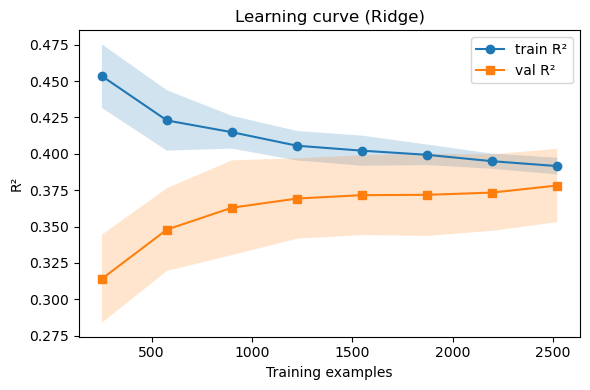

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    rg_pipe,
    X_features_clean,
    y_reg,
    cv=cv,
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, marker="o", label="train R²")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, marker="s", label="val R²")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.xlabel("Training examples")
plt.ylabel("R²")
plt.title("Learning curve (Ridge)")
plt.legend()
plt.tight_layout()
plt.show()


In [130]:
alphas = np.logspace(-4, 4, 9)  # 너무 극단적이지 않게 범위 줄임
MSE = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for a in alphas:
    model_reg = make_pipeline(
        StandardScaler(),
        Ridge(alpha=a, max_iter=10000)
    )

    scores = cross_validate(
        model_reg,
        X_features_clean,
        y_reg,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    mean_mse = -np.mean(scores['test_score'])
    MSE.append(mean_mse)

    print(f"alpha={a:.4e}, CV MSE={mean_mse:.3f}")

best_alpha = alphas[np.argmin(MSE)]
print("\nBest alpha from CV:", best_alpha)


alpha=1.0000e-04, CV MSE=690.742
alpha=1.0000e-03, CV MSE=690.742
alpha=1.0000e-02, CV MSE=690.742
alpha=1.0000e-01, CV MSE=690.739
alpha=1.0000e+00, CV MSE=690.710
alpha=1.0000e+01, CV MSE=690.496
alpha=1.0000e+02, CV MSE=690.392
alpha=1.0000e+03, CV MSE=706.319
alpha=1.0000e+04, CV MSE=851.532

Best alpha from CV: 100.0


In [129]:
from sklearn.model_selection import learning_curve, KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

cv = KFold(n_splits=5, shuffle=True, random_state=42)

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
train_sizes = np.linspace(0.1, 1.0, 8)  # 전체 데이터의 10% ~ 100%

lc_res = {}

for a in alphas:
    pipe = Pipeline([
        ("sc", PowerTransformer(method="yeo-johnson")),
        ("rg", Ridge(alpha=a)),
    ])

    ts, tr_scores, va_scores = learning_curve(
        pipe,
        X_features_clean,
        y_reg,
        train_sizes=train_sizes,
        cv=cv,
        scoring="r2",
        shuffle=True,
    )

    # fold 평균 / 표준편차
    tr_mean = tr_scores.mean(axis=1)
    tr_std  = tr_scores.std(axis=1)
    va_mean = va_scores.mean(axis=1)
    va_std  = va_scores.std(axis=1)

    lc_res[a] = {
        "train_sizes": ts,
        "tr_mean": tr_mean,
        "tr_std": tr_std,
        "va_mean": va_mean,
        "va_std": va_std,
    }


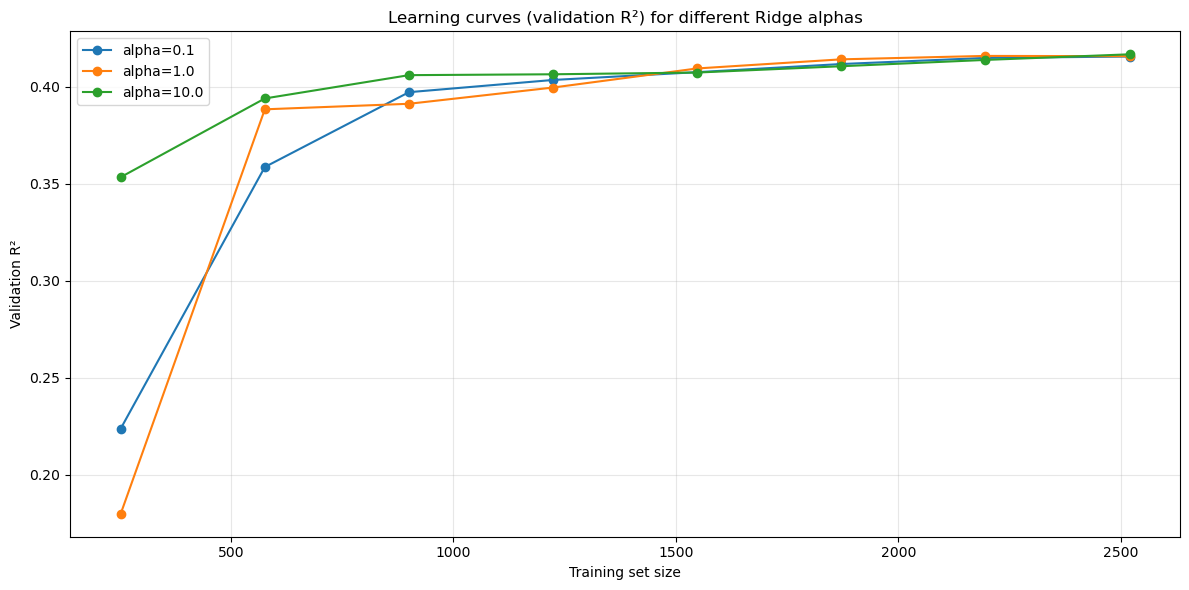

In [131]:
plt.figure(figsize=(12, 6))

for a in [0.1, 1.0, 10.0]:
    d = lc_res[a]
    ts = d["train_sizes"]
    plt.plot(ts, d["va_mean"], marker="o", label=f"alpha={a}")

plt.xlabel("Training set size")
plt.ylabel("Validation R²")
plt.title("Learning curves (validation R²) for different Ridge alphas")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

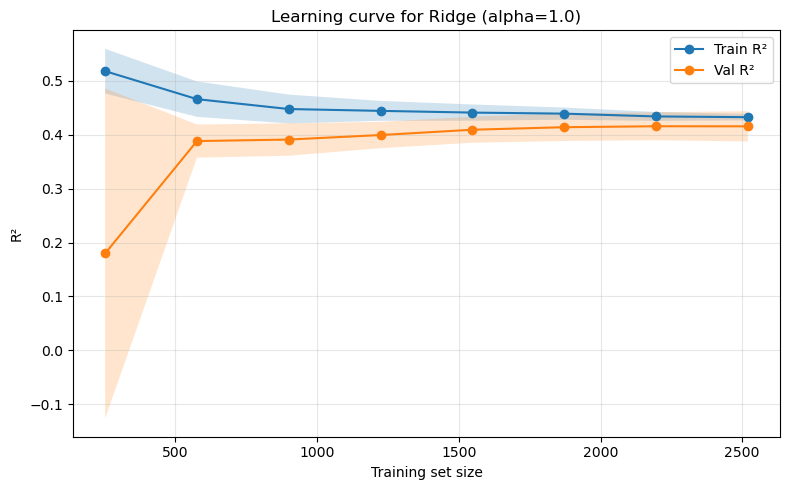

In [132]:
a_sel = 1.0  # 예: alpha=1.0

d = lc_res[a_sel]
ts = d["train_sizes"]

plt.figure(figsize=(8, 5))
plt.plot(ts, d["tr_mean"], marker="o", label="Train R²")
plt.plot(ts, d["va_mean"], marker="o", label="Val R²")
plt.fill_between(ts, d["tr_mean"] - d["tr_std"], d["tr_mean"] + d["tr_std"], alpha=0.2)
plt.fill_between(ts, d["va_mean"] - d["va_std"], d["va_mean"] + d["va_std"], alpha=0.2)

plt.xlabel("Training set size")
plt.ylabel("R²")
plt.title(f"Learning curve for Ridge (alpha={a_sel})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Fianl model


In [133]:
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import spearmanr
import numpy as np

# 최종 파이프라인
final_pipe = Pipeline([
    ("sc", PowerTransformer(method="yeo-johnson")),
    ("rg", Ridge(alpha=1.0)),
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# R2
cv_r2 = cross_val_score(final_pipe, X_features_clean, y_reg,
                        cv=cv, scoring="r2")

# RMSE
cv_mse = cross_val_score(final_pipe, X_features_clean, y_reg,
                         cv=cv, scoring="neg_mean_squared_error")
cv_rmse = np.sqrt(-cv_mse)

# MAE
cv_mae = -cross_val_score(final_pipe, X_features_clean, y_reg,
                          cv=cv, scoring="neg_mean_absolute_error")

# Spearman
sp_scores = []
for tr_idx, te_idx in cv.split(X_features_clean):
    Xtr = X_features_clean.iloc[tr_idx]
    Xte = X_features_clean.iloc[te_idx]
    ytr = y_reg.iloc[tr_idx]
    yte = y_reg.iloc[te_idx]

    final_pipe.fit(Xtr, ytr)
    pred = final_pipe.predict(Xte)
    rho, _ = spearmanr(yte, pred)
    sp_scores.append(rho)

print("Final model (Power-YJ + Ridge α=1.0)")
print(f"  R2    : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"  RMSE  : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")
print(f"  MAE   : {cv_mae.mean():.3f} ± {cv_mae.std():.3f}")
print(f"  Spear : {np.mean(sp_scores):.3f} ± {np.std(sp_scores):.3f}")


Final model (Power-YJ + Ridge α=1.0)
  R2    : 0.416 ± 0.028
  RMSE  : 25.465 ± 0.699
  MAE   : 20.632 ± 0.533
  Spear : 0.658 ± 0.020


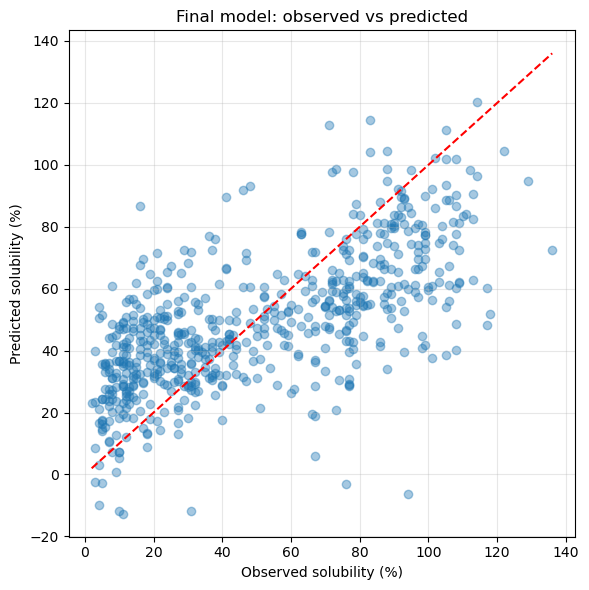

In [134]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# hold-out split (optional 시각화용)
Xtr, Xte, ytr, yte = train_test_split(
    X_features_clean, y_reg, test_size=0.2, random_state=42
)

final_pipe.fit(Xtr, ytr)
y_pred = final_pipe.predict(Xte)

plt.figure(figsize=(6,6))
plt.scatter(yte, y_pred, alpha=0.4)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], "r--")
plt.xlabel("Observed solubility (%)")
plt.ylabel("Predicted solubility (%)")
plt.title("Final model: observed vs predicted")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


although it is unclear at this point, if PCA will increase the performace...
we will try since we have high cor dims


In [135]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import spearmanr

# 이미 있으면 재사용, 없으면 생성
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 테스트할 PCA 차원 수
pca_list = [5, 10, 15, 20]

rows = []

for k in pca_list:
    name = f"PCA_{k}"

    pipe = Pipeline([
        ("sc", PowerTransformer(method="yeo-johnson")),
        ("pca", PCA(n_components=k, random_state=42)),
        ("rg", Ridge(alpha=1.0)),
    ])

    # --- R2 ---
    cv_r2 = cross_val_score(
        pipe, X_features_clean, y_reg,
        cv=cv, scoring="r2"
    )

    # --- RMSE (from neg MSE) ---
    cv_mse = cross_val_score(
        pipe, X_features_clean, y_reg,
        cv=cv, scoring="neg_mean_squared_error"
    )
    cv_rmse = np.sqrt(-cv_mse)

    # --- MAE (from neg MAE) ---
    cv_mae = cross_val_score(
        pipe, X_features_clean, y_reg,
        cv=cv, scoring="neg_mean_absolute_error"
    )
    cv_mae = -cv_mae

    # --- Spearman (fold별로 직접 계산) ---
    sp = []
    for tr_idx, te_idx in cv.split(X_features_clean):
        Xtr = X_features_clean.iloc[tr_idx]
        Xte = X_features_clean.iloc[te_idx]
        ytr = y_reg.iloc[tr_idx]
        yte = y_reg.iloc[te_idx]

        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xte)

        rho, _ = spearmanr(yte, pred)
        sp.append(rho)

    rows.append({
        "Model": name,
        "R2_mean":   cv_r2.mean(),
        "R2_std":    cv_r2.std(),
        "RMSE_mean": cv_rmse.mean(),
        "RMSE_std":  cv_rmse.std(),
        "MAE_mean":  cv_mae.mean(),
        "MAE_std":   cv_mae.std(),
        "Spearman_mean": np.mean(sp),
        "Spearman_std":  np.std(sp),
    })

pca_results = pd.DataFrame(rows).set_index("Model")
print(pca_results.round(3))


        R2_mean  R2_std  RMSE_mean  RMSE_std  MAE_mean  MAE_std  \
Model                                                             
PCA_5     0.295   0.025     27.984     0.597    23.195    0.430   
PCA_10    0.400   0.023     25.805     0.581    20.980    0.530   
PCA_15    0.403   0.021     25.734     0.547    20.892    0.495   
PCA_20    0.409   0.023     25.610     0.579    20.800    0.509   

        Spearman_mean  Spearman_std  
Model                                
PCA_5           0.549         0.020  
PCA_10          0.645         0.022  
PCA_15          0.650         0.019  
PCA_20          0.654         0.020  
